In [29]:
import numpy as np
import scipy.optimize as op
import datetime
import emcee
import matplotlib.pyplot as plt
import corner
from scipy.stats import norm, halfnorm
%matplotlib inline

In [30]:
mars = np.genfromtxt('harp_mars.dat', usecols=np.arange(0, 9))
jupiter = np.genfromtxt('harp_jupiter.dat', usecols=np.arange(0, 8))
uranus = np.genfromtxt('harp_uranus.dat', usecols=np.arange(0, 8))

In [31]:
mars_etamb = mars[:,5]
jupiter_etamb = jupiter[:,5]
uranus_etamb = uranus[:,5]

mars_dates = mars[:,0]
jupiter_dates = jupiter[:,0]
uranus_dates = uranus[:,0]

mars = mars[mars[:,1] > 5]
mars = mars[mars[:,1] < 19]
mars = mars[mars[:,5] > 0]
jupiter = jupiter[jupiter[:,1] > 5]
jupiter = jupiter[jupiter[:,1] < 19]
jupiter = jupiter[jupiter[:,5] > 0]
uranus = uranus[uranus[:,1] > 5]
uranus = uranus[uranus[:,1] < 19]
uranus = uranus[uranus[:,5] > 0]

planets_etamb = np.concatenate((mars_etamb, jupiter_etamb, uranus_etamb), axis=0)
raw_dates = np.concatenate((mars_dates, jupiter_dates, uranus_dates), axis=0)
dates = [datetime.datetime.strptime(str(int(date)),'%Y%m%d') for date in raw_dates]

In [32]:
oldest = min(dates)
days = np.array([np.float64((date - oldest).days) + 1 for date in dates])

In [33]:
m_true = 0.0
b_true = .5

lnyerr_true = -2.3
lnV_true = -1.6

In [34]:
def lnlike(theta, x, y):
    m, b, lnyerr, lnV = theta
    #print(m, b, lnyerr, lnV)
    angle = np.arctan(m)
    delt = -np.sin(angle)*x + np.cos(angle)*y - b*np.cos(angle)
    sigsq = (np.exp(lnyerr)*y)**2 * np.cos(angle)**2
    return -np.sum(0.5*np.log(sigsq + np.exp(lnV))) - \
            np.sum(0.5*(delt**2)/(sigsq + np.exp(lnV)))

In [35]:
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_true, b_true, lnyerr_true, lnV_true], args=(days, planets_etamb))
m_ml, b_ml, lnyerr_ml, lnV_ml= result["x"]

In [36]:
print(m_ml, b_ml, lnyerr_ml, lnV_ml)
print(np.exp(lnyerr_ml), np.exp(lnV_ml))

1.97767339399e-06 0.534759773444 -10.0931937748 -4.29547849513
4.13601055901e-05 0.013630048225


In [37]:
def lnprior(theta):
    m, b, lnyerr, lnV= theta
    if 0.0 < b < 1.0:
#   if -1.0 < m < 1.0 and 0.0 < b < 1.0 and -5.0 < lnyerr < 0.0 and -3.0 < lnV < 0.0:
        pri_m = norm.logpdf(m, 0.0, 1.0)
        pri_lnyerr = norm.logpdf(lnyerr, -2.5, 2.5/3.0)
        pri_lnV = halfnorm.logpdf(np.sqrt(np.exp(lnV)), 0, .1)
        return pri_m + pri_lnyerr + pri_lnV
    return -np.inf

In [38]:
def lnprob(theta, x, y):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y)

In [39]:
ndim, nwalkers = 4, 200
# pos = [result["x"] + np.random.randn(ndim)*1e-4*[.2, .1, .5, .3, .3] for i in range(nwalkers)] #nwalkers x ndim entries
pos = [np.random.randn(ndim)*1e-4*[0.001, .6, -2.5, -2.5] for i in range(nwalkers)]

In [40]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(days, planets_etamb), threads=4, a=4.0)

In [41]:
sampler.run_mcmc(pos, 1000)

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/rebeccachen/anaconda/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


(array([[  4.46486773e-06,   5.39459192e-01,  -3.51189328e+00,
          -4.26362744e+00],
        [  8.25094026e-06,   5.27716967e-01,  -4.10970319e+00,
          -4.26002462e+00],
        [  1.39195537e-06,   5.27606724e-01,  -4.53712297e+00,
          -4.18315478e+00],
        [  7.05162195e-07,   5.33083487e-01,  -4.48361756e+00,
          -4.29624313e+00],
        [  1.51879781e-05,   5.23866249e-01,  -3.27727034e+00,
          -4.28169513e+00],
        [  6.00170391e-06,   5.32596701e-01,  -4.12536942e+00,
          -4.29995626e+00],
        [  2.94642337e-06,   5.31272309e-01,  -3.70765808e+00,
          -4.39661388e+00],
        [  2.41662154e-06,   5.31101386e-01,  -3.94130691e+00,
          -4.18149768e+00],
        [ -2.25693363e-06,   5.46276285e-01,  -3.85187476e+00,
          -4.32409785e+00],
        [  5.31252399e-06,   5.33807649e-01,  -3.30593995e+00,
          -4.28229156e+00],
        [ -8.70964444e-07,   5.38154458e-01,  -3.73448048e+00,
          -4.34320838e+00],

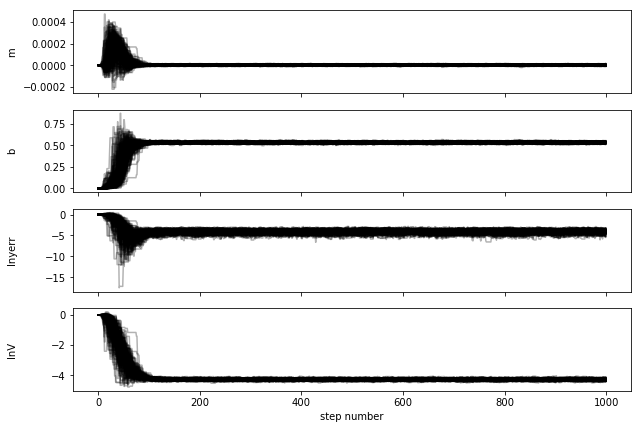

In [42]:
plt.figure(1)
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.chain
labels = ["m", "b", "lnyerr", "lnV"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i].T, "k", alpha=0.3)
#     ax.set_xlim(0, len(samples))
    #(nwalkers, nsteps, dim)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
fig.savefig("200walkers_smallinit_a4.0_1000steps_nobias.png")
plt.show()

In [43]:
flat_samples = sampler.chain[:, 200:, :].reshape((-1, ndim))

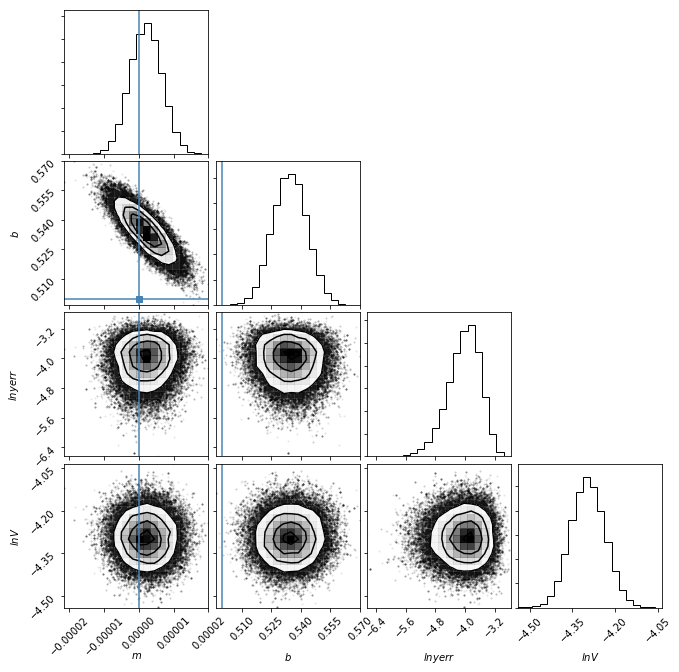

In [44]:
fig = corner.corner(flat_samples, labels=["$m$", "$b$", "$lnyerr$", "$lnV$"],
                      truths=[m_true, b_true, lnyerr_true, lnV_true])
fig.savefig("200walkers_smallinit_a4.0_1000steps_nobias_corner.png")

In [28]:
from IPython.display import display, Math
results = []

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    results.append(mcmc)
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>